## `Ames Housing DataSet - Kaggle`
> Gabriel Perez Prieto

## 0 - Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# setting max columns limit
pd.options.display.max_columns = 500
pd.options.display.max_rows = 500

# plot style to be used
plt.style.use('seaborn-whitegrid')

# ML Libraries
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, BayesianRidge
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import VotingRegressor, RandomForestRegressor
from xgboost import XGBRegressor

import statsmodels.api as sm

from scipy.stats import skew, norm

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

## 1 - Loading Data

In [2]:
# reading datasets into memmory
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')
print(f'Shape - Training Set: {train.shape}')
print(f'Shape - Testing Set: {test.shape}')

Shape - Training Set: (1460, 81)
Shape - Testing Set: (1459, 80)


In [3]:
# changing the column names to lower and underscore
train.columns = [column.lower().replace(' ','_') for column in train.columns]
test.columns = [column.lower().replace(' ','_') for column in test.columns]

In [4]:
# drop 'id' column for now
train_id = train['id']
train.drop('id', axis=1, inplace=True)
test_id = test['id']
test.drop('id', axis=1, inplace=True)

## 2 - Data Cleaning

### 2.1 - Handling Null Values


In [5]:
# transform categorical columns to numerical - This will fix some null values as well!
rating_dict = {'Ex': 4, 'Gd': 3, 'TA': 2, 'Fa': 1, 'Po': 1 , np.nan: 0}

qualitative_to_numeric_dict = {'poolqc': rating_dict,
                               'fireplacequ': rating_dict,
                               'garagecond': rating_dict,
                               'garagequal': rating_dict,
                               'bsmtexposure': {'Gd': 4,'Av': 3,'Mn': 2,'No': 1,np.nan: 0},
                               'bsmtfintype2': {'GLQ': 6,'ALQ': 5,'BLQ': 4,'Rec': 3,'LwQ': 2,'Unf': 1,np.nan: 0},
                               'bsmtcond': rating_dict,
                               'bsmtqual': rating_dict,
                               'bsmtfintype1': {'GLQ': 6,'ALQ': 5,'BLQ': 4,'Rec': 3,'LwQ': 2,'Unf': 1,np.nan: 0},
                               'exterqual': rating_dict,
                               'extercond': rating_dict,
                               'heatingqc': rating_dict,
                               'centralair': {'Y': 1,'N': 0},
                               'kitchenqual': rating_dict
                              }  

# replace qualitative values by a range of integers
train.replace(qualitative_to_numeric_dict, inplace=True)
test.replace(qualitative_to_numeric_dict, inplace=True)

In [6]:
# checking for null columns again as see what is left
train.isnull().mean()[train.isnull().mean() > 0].sort_values(ascending=False)

miscfeature     0.963014
alley           0.937671
fence           0.807534
lotfrontage     0.177397
garagefinish    0.055479
garageyrblt     0.055479
garagetype      0.055479
masvnrarea      0.005479
masvnrtype      0.005479
electrical      0.000685
dtype: float64

In [7]:
test.isnull().mean()[test.isnull().mean() > 0].sort_values(ascending=False)

miscfeature     0.965045
alley           0.926662
fence           0.801234
lotfrontage     0.155586
garagefinish    0.053461
garageyrblt     0.053461
garagetype      0.052090
masvnrtype      0.010966
masvnrarea      0.010281
mszoning        0.002742
functional      0.001371
bsmthalfbath    0.001371
bsmtfullbath    0.001371
utilities       0.001371
exterior1st     0.000685
exterior2nd     0.000685
saletype        0.000685
bsmtfinsf1      0.000685
bsmtfinsf2      0.000685
bsmtunfsf       0.000685
garagecars      0.000685
garagearea      0.000685
totalbsmtsf     0.000685
dtype: float64

In [8]:
# impute missing values
def input_missing_values(*dataframes, train_dataframe=train):
    for dataframe in dataframes:
        for column in ['miscfeature', 'alley', 'fence', 'garagefinish', 'garagetype', 'masvnrtype']:
            dataframe[column] = dataframe[column].fillna('None')

        for column in ['lotfrontage']:
#             dataframe[column] = dataframe[column].fillna(train_dataframe[column].median())
            dataframe[column] = train_dataframe.groupby("neighborhood")["lotfrontage"] \
            .transform(lambda x: x.fillna(x.median()))

        for column in ['garageyrblt', 'masvnrarea', 'bsmthalfbath', 'bsmtfullbath',
                       'bsmtfinsf1', 'bsmtfinsf2', 'bsmtunfsf', 'garagecars', 'garagearea', 'totalbsmtsf']:
            dataframe[column] = dataframe[column].fillna(0)

        for column in ['mszoning', 'functional', 'exterior1st', 'exterior2nd', 'saletype', 'electrical', 'utilities']:
            dataframe[column] = dataframe[column].fillna(train_dataframe[column].mode()[0])

input_missing_values(train, test)

In [9]:
# checking for duplicated values
print(f'Duplicated Values - Training Set: {train.duplicated().sum()}')
print(f'Duplicated Values - Testing Set: {test.duplicated().sum()}')

Duplicated Values - Training Set: 0
Duplicated Values - Testing Set: 0


## 3 - EDA ( Exploratory Data Analysis )

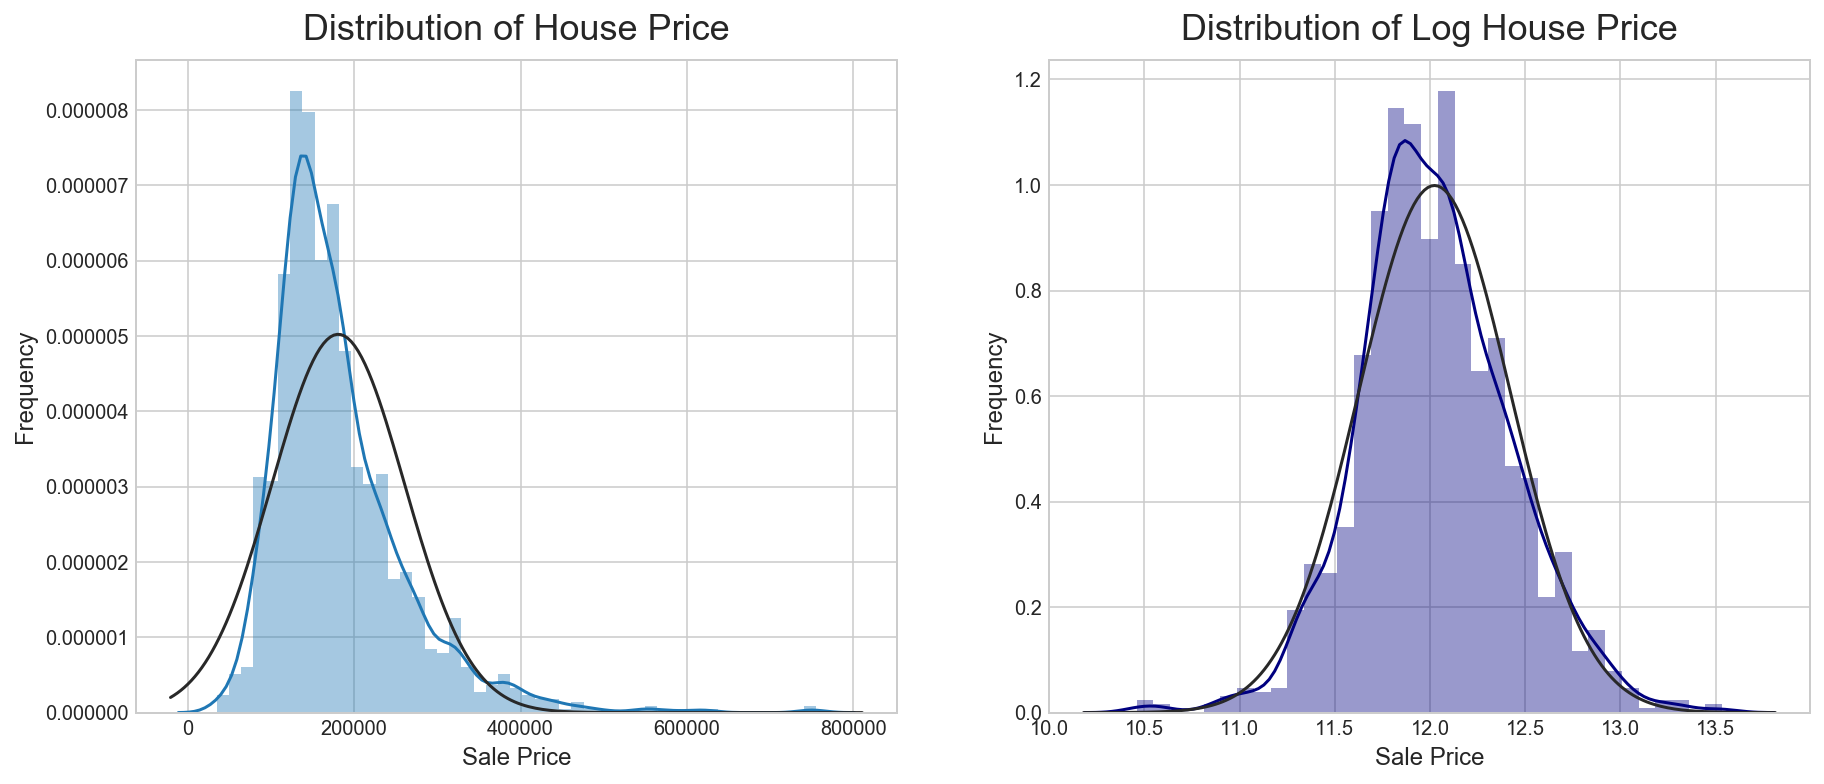

In [10]:
# plotting distribution of sale price vs log sale price (Normalize)
plt.figure(figsize=(15,6))

plt.subplot(1, 2, 1)
sns.distplot(train['saleprice'], fit=norm)
plt.title('Distribution of House Price', size=18, pad=10)
plt.xlabel('Sale Price', size=12)
plt.ylabel('Frequency', size=12)

plt.subplot(1, 2, 2)
sns.distplot(np.log1p(train['saleprice']) ,fit=norm, color='navy')
plt.title('Distribution of Log House Price', size=18, pad=10)
plt.xlabel('Sale Price', size=12)
plt.ylabel('Frequency', size=12);

### 3.1 - Correlations HeatMap

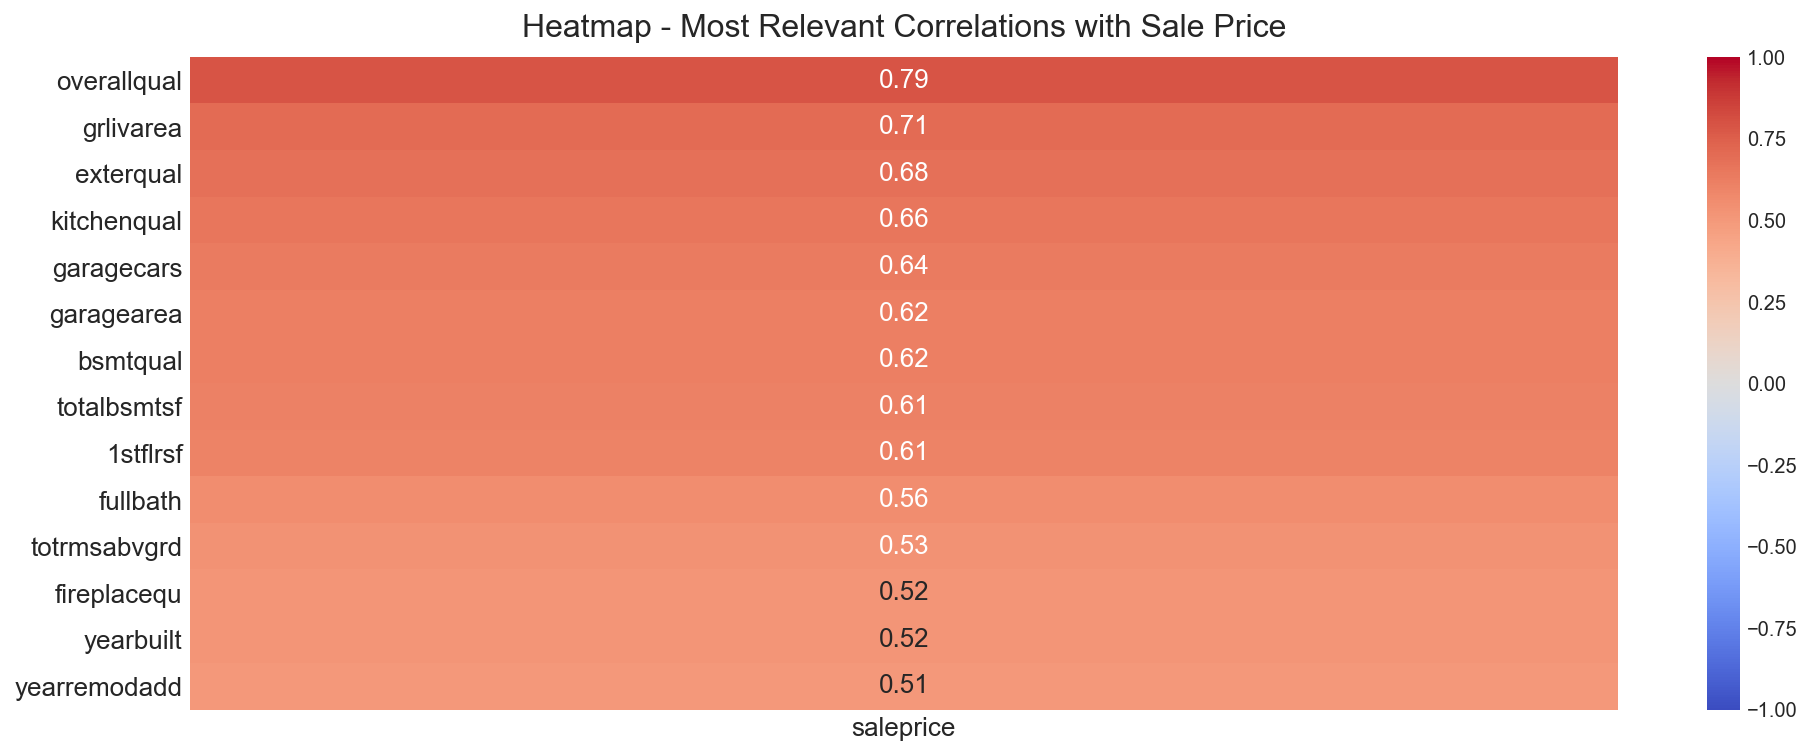

In [11]:
# correlations with target variable ['saleprice']
correlations_saleprice = train.corr()[['saleprice']].abs().sort_values(['saleprice'], ascending=False)

# creating a list with column names for columns with correlation > .5 with ['saleprice']
strong_correlations = correlations_saleprice.loc[correlations_saleprice['saleprice'] >= .5][1:].index.values

# creating a heatmap for the most relevant correlations with saleprice
plt.figure(figsize=(16,6))
sns.heatmap(correlations_saleprice.loc[correlations_saleprice['saleprice'] >= .5][1:],
            annot=True, annot_kws={"size": 13}, cmap='coolwarm', vmin=-1, vmax=1)
plt.yticks(size=13)
plt.xticks(size=13)
plt.title('Heatmap - Most Relevant Correlations with Sale Price', size=16, pad=10);

### 3.2 - Scatterplots of  Numerical Variables - Strong Correlation with Saleprice

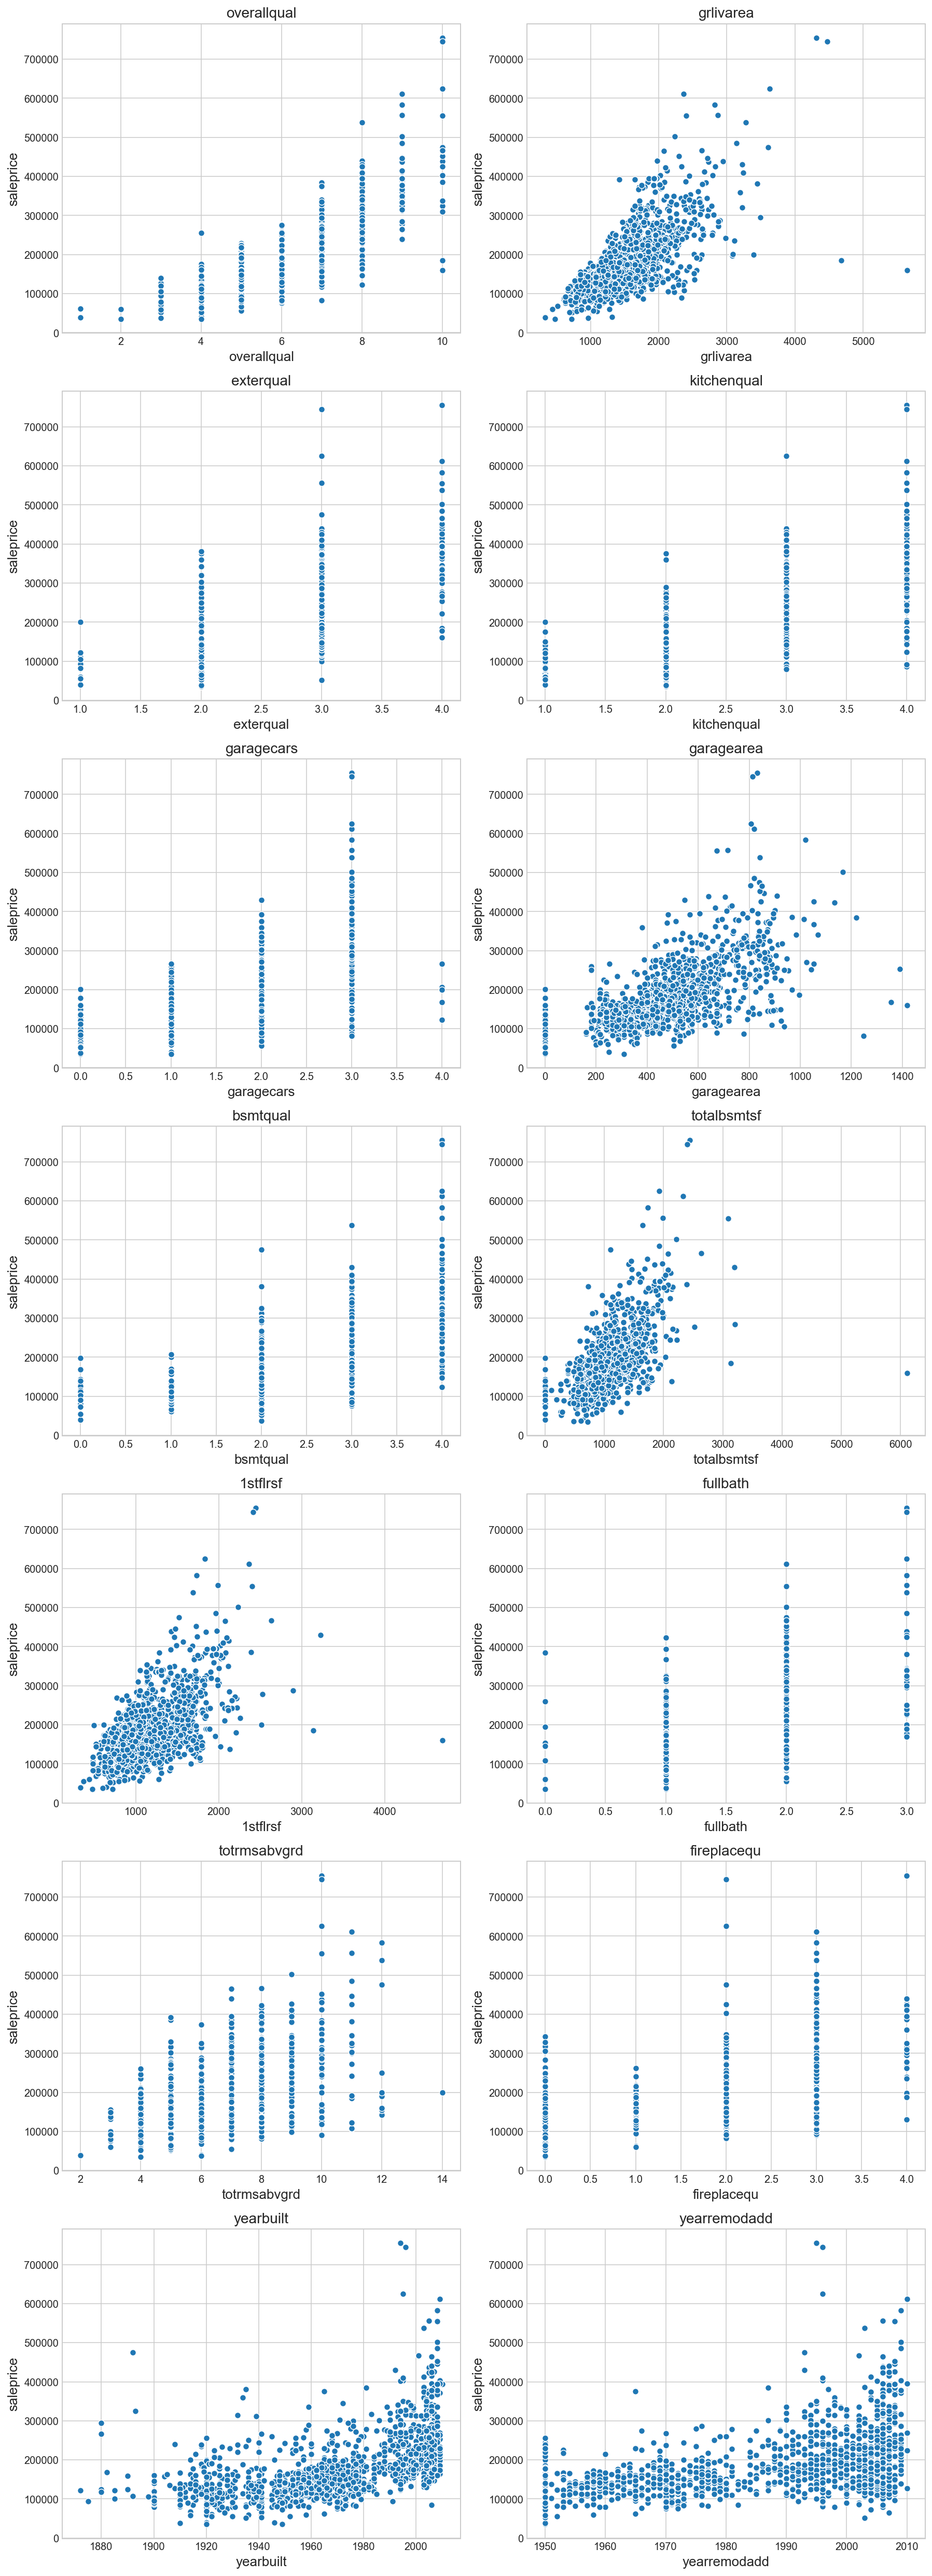

In [12]:
# creating scatterplots for numerical variables with ['saleprice']
nrows=int(np.ceil((len(strong_correlations))/2))
fig, ax = plt.subplots(nrows=nrows, ncols=2, figsize= (13, 2.5 * len(strong_correlations)))

plt.tight_layout(pad=4)
ax = ax.ravel() 
for index, column in enumerate(strong_correlations):
    sns.scatterplot(x = train[column], y = train['saleprice'], ax=ax[index]) 
    ax[index].set_title(strong_correlations[index], size=14)
    ax[index].set_xlabel(strong_correlations[index], size=13)
    ax[index].set_ylabel('saleprice', size=13);

### 3.3 - Chcecking Outliers - From Scatterplots

In [13]:
train.loc[train['totalbsmtsf'] > 5000]

,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,lotconfig,landslope,neighborhood,condition1,condition2,bldgtype,housestyle,overallqual,overallcond,yearbuilt,yearremodadd,roofstyle,roofmatl,exterior1st,exterior2nd,masvnrtype,masvnrarea,exterqual,extercond,foundation,bsmtqual,bsmtcond,bsmtexposure,bsmtfintype1,bsmtfinsf1,bsmtfintype2,bsmtfinsf2,bsmtunfsf,totalbsmtsf,heating,heatingqc,centralair,electrical,1stflrsf,2ndflrsf,lowqualfinsf,grlivarea,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,kitchenqual,totrmsabvgrd,functional,fireplaces,fireplacequ,garagetype,garageyrblt,garagefinish,garagecars,garagearea,garagequal,garagecond,paveddrive,wooddecksf,openporchsf,enclosedporch,3ssnporch,screenporch,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
1298,60,RL,313.0,63887,Pave,None,IR3,Bnk,AllPub,Corner,Gtl,Edwards,Feedr,Norm,1Fam,2Story,10,5,2008,2008,Hip,ClyTile,Stucco,Stucco,Stone,796.0,4,2,PConc,4,2,4,6,5644,1,0,466,6110,GasA,4,1,SBrkr,4692,950,0,5642,2,0,2,1,3,1,4,12,Typ,3,3,Attchd,2008.0,Fin,2,1418,2,2,Y,214,292,0,0,0,480,3,None,None,0,1,2008,New,Partial,160000


In [14]:
train.loc[train['1stflrsf'] > 4000]

,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,lotconfig,landslope,neighborhood,condition1,condition2,bldgtype,housestyle,overallqual,overallcond,yearbuilt,yearremodadd,roofstyle,roofmatl,exterior1st,exterior2nd,masvnrtype,masvnrarea,exterqual,extercond,foundation,bsmtqual,bsmtcond,bsmtexposure,bsmtfintype1,bsmtfinsf1,bsmtfintype2,bsmtfinsf2,bsmtunfsf,totalbsmtsf,heating,heatingqc,centralair,electrical,1stflrsf,2ndflrsf,lowqualfinsf,grlivarea,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,kitchenqual,totrmsabvgrd,functional,fireplaces,fireplacequ,garagetype,garageyrblt,garagefinish,garagecars,garagearea,garagequal,garagecond,paveddrive,wooddecksf,openporchsf,enclosedporch,3ssnporch,screenporch,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
1298,60,RL,313.0,63887,Pave,None,IR3,Bnk,AllPub,Corner,Gtl,Edwards,Feedr,Norm,1Fam,2Story,10,5,2008,2008,Hip,ClyTile,Stucco,Stucco,Stone,796.0,4,2,PConc,4,2,4,6,5644,1,0,466,6110,GasA,4,1,SBrkr,4692,950,0,5642,2,0,2,1,3,1,4,12,Typ,3,3,Attchd,2008.0,Fin,2,1418,2,2,Y,214,292,0,0,0,480,3,None,None,0,1,2008,New,Partial,160000


In [15]:
train.loc[(train['grlivarea'] > 4000) & (train['saleprice'] < 300000)]

,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,lotconfig,landslope,neighborhood,condition1,condition2,bldgtype,housestyle,overallqual,overallcond,yearbuilt,yearremodadd,roofstyle,roofmatl,exterior1st,exterior2nd,masvnrtype,masvnrarea,exterqual,extercond,foundation,bsmtqual,bsmtcond,bsmtexposure,bsmtfintype1,bsmtfinsf1,bsmtfintype2,bsmtfinsf2,bsmtunfsf,totalbsmtsf,heating,heatingqc,centralair,electrical,1stflrsf,2ndflrsf,lowqualfinsf,grlivarea,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,kitchenqual,totrmsabvgrd,functional,fireplaces,fireplacequ,garagetype,garageyrblt,garagefinish,garagecars,garagearea,garagequal,garagecond,paveddrive,wooddecksf,openporchsf,enclosedporch,3ssnporch,screenporch,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
523,60,RL,130.0,40094,Pave,None,IR1,Bnk,AllPub,Inside,Gtl,Edwards,PosN,PosN,1Fam,2Story,10,5,2007,2008,Hip,CompShg,CemntBd,CmentBd,Stone,762.0,4,2,PConc,4,2,4,6,2260,1,0,878,3138,GasA,4,1,SBrkr,3138,1538,0,4676,1,0,3,1,3,1,4,11,Typ,1,3,BuiltIn,2007.0,Fin,3,884,2,2,Y,208,406,0,0,0,0,0,None,None,0,10,2007,New,Partial,184750
1298,60,RL,313.0,63887,Pave,None,IR3,Bnk,AllPub,Corner,Gtl,Edwards,Feedr,Norm,1Fam,2Story,10,5,2008,2008,Hip,ClyTile,Stucco,Stucco,Stone,796.0,4,2,PConc,4,2,4,6,5644,1,0,466,6110,GasA,4,1,SBrkr,4692,950,0,5642,2,0,2,1,3,1,4,12,Typ,3,3,Attchd,2008.0,Fin,2,1418,2,2,Y,214,292,0,0,0,480,3,None,None,0,1,2008,New,Partial,160000


In [16]:
# dropping outliers
train.drop(train.loc[(train['grlivarea'] > 4000) & (train['saleprice'] < 300000)].index, inplace=True)
train.reset_index(drop=True, inplace=True)
print(train.shape)

(1458, 80)


### 3.4 - Correlation Amongst Strong Correlated Variables ( With SalePrice ) - Look for Possible Interaction Terms

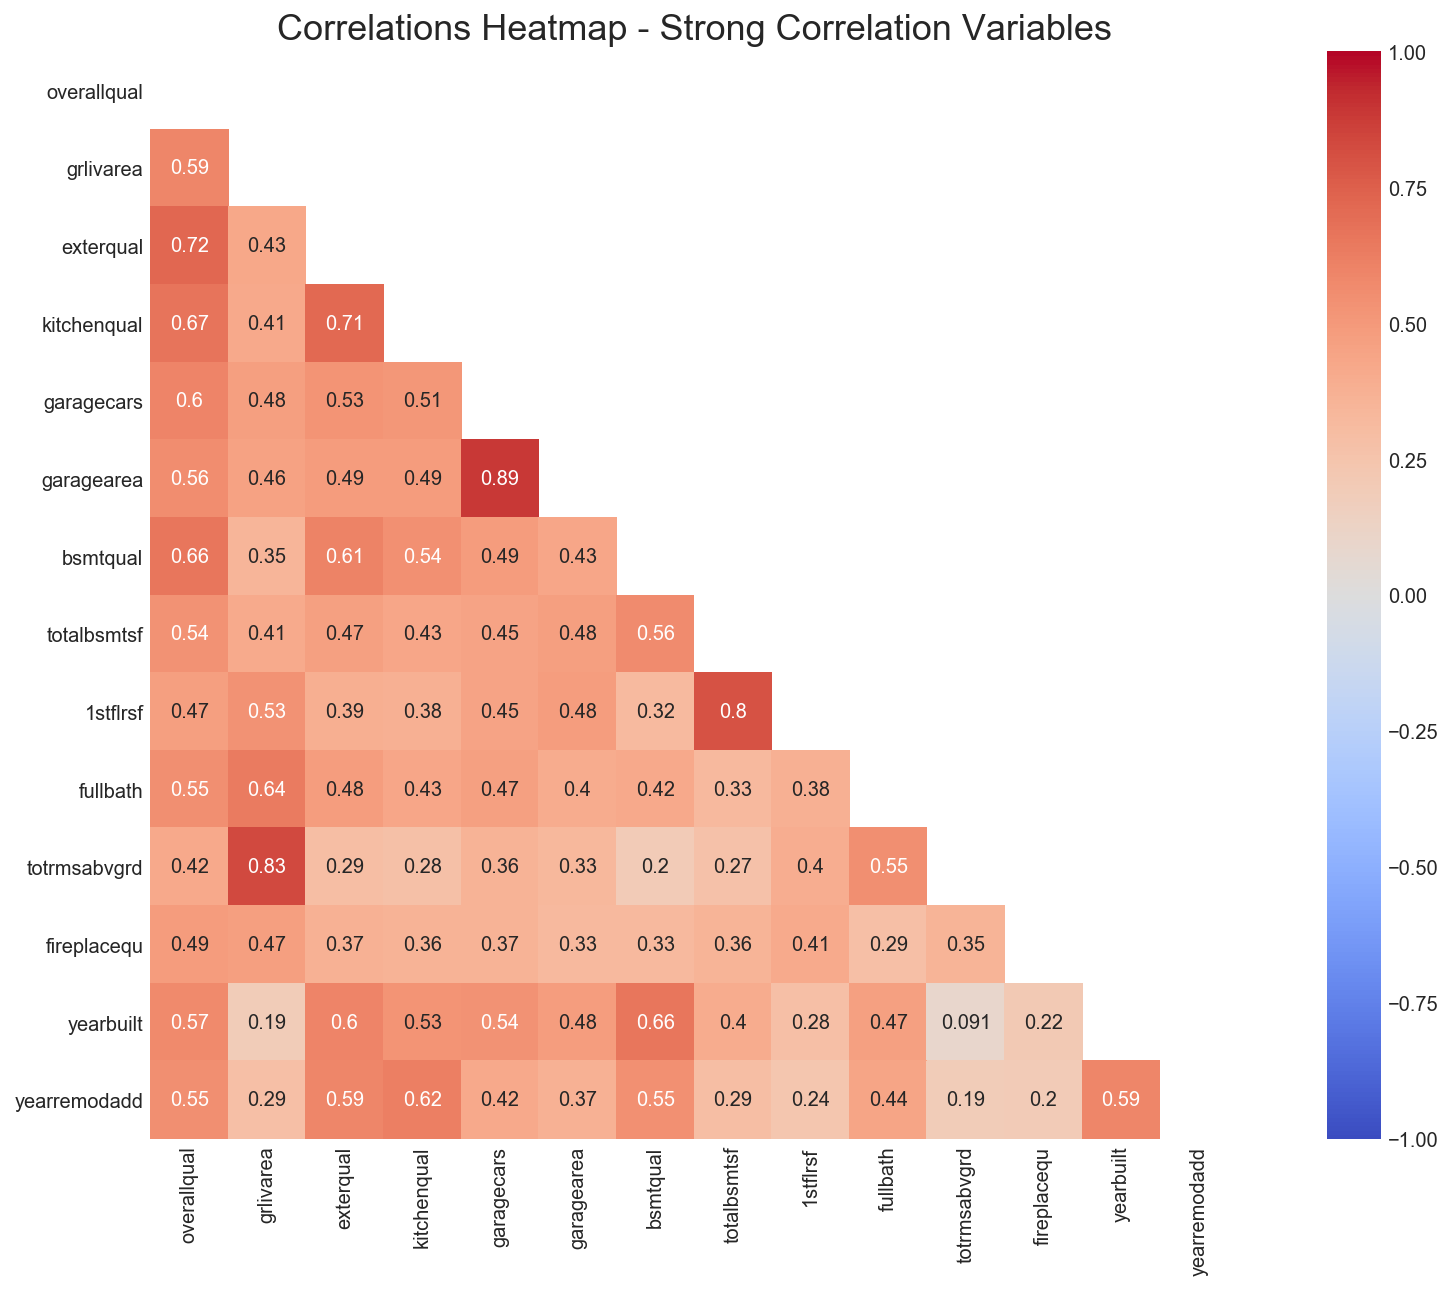

In [17]:
# plotting heatmap to look for possible interaction terms

# create a figure
plt.figure(figsize=(16,10))

# correlations data
corr = train[strong_correlations].corr()

# Set up mask so triangle at the top is white
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

# Set title
plt.title('Correlations Heatmap - Strong Correlation Variables',fontsize=18)

# create heatmap
sns.heatmap(corr, mask=mask, square=True, annot=True, cmap='coolwarm', vmin=-1, vmax=1);

# Adapted from https://seaborn.pydata.org/generated/seaborn.heatmap.html

## 4 - Feature Engineering

### 4.1 - Creating Interaction Terms For Other Variables

In [18]:
def new_features(*args):
    for arg in args:
        arg['totalarea'] = arg['totalbsmtsf'] + arg['1stflrsf'] + arg['2ndflrsf']
                
        arg['remodminusbuilt'] = arg['yearremodadd'] - arg['yearbuilt']

        arg['totalsf'] = (arg['bsmtfinsf1'] + arg['bsmtfinsf2'] + arg['1stflrsf'] + arg['2ndflrsf'])

        arg['totalbathrooms'] = (arg['fullbath'] + (0.5 * arg['halfbath']) + arg['bsmtfullbath'] +
                                  (0.5 * arg['bsmthalfbath']))

        arg['totalporchsf'] = (arg['openporchsf'] + arg['3ssnporch'] + arg['enclosedporch'] +
                                 arg['screenporch'] + arg['wooddecksf'])
        
        arg['haspool'] = arg['poolarea'].apply(lambda x: 1 if x > 0 else 0)
        arg['has2ndfloor'] = arg['2ndflrsf'].apply(lambda x: 1 if x > 0 else 0)
        arg['hasgarage'] = arg['garagearea'].apply(lambda x: 1 if x > 0 else 0)
        arg['hasbsmt'] = arg['totalbsmtsf'].apply(lambda x: 1 if x > 0 else 0)
        arg['hasfireplace'] = arg['fireplaces'].apply(lambda x: 1 if x > 0 else 0)

new_features(train, test)

In [19]:
# define numerical and nominal columns
numerical_variables = list(train.select_dtypes(exclude='object').columns)
nominal_variables = list(train.select_dtypes(include='object').columns)

### 4.2 - Skewed Features

In [20]:
skewed_features = train[numerical_variables].drop('saleprice', axis=1).apply(lambda x: abs(skew(x.dropna())))
high_skewed = skewed_features[skewed_features > 0.5].index

In [21]:
# defining a function to create boxplot for nominal variables
def subplot_histograms(dataframe, list_of_columns, function=np.log1p):
      
    nrows = int(np.ceil(len(list_of_columns)/2)) # Makes sure you have enough rows
    ncols = 2
    fig, ax = plt.subplots(nrows=nrows,
                           ncols=ncols,
                           figsize=(14, 5 * nrows))
    plt.tight_layout(pad=4)

    for i in range(nrows):
        for j in range(ncols):
            if j % 2 == 0:
                ax[i,j].hist(dataframe[list_of_columns[i]],
                             label='Skewness: {}'.format(dataframe[list_of_columns[i]].skew()))
                ax[i,j].set_title(list_of_columns[i], size=14)

                ax[i,j].legend(loc='best')
            else:
                ax[i,j].hist(dataframe[list_of_columns[i]].map(function), color='purple',
                             label='Skewness: {}'.format(dataframe[list_of_columns[i]].map(function).skew()))
                ax[i,j].set_title(str(list_of_columns[i])+ ' - ' + 'Log1p Transformation', size=14)
                ax[i,j].legend(loc='best')

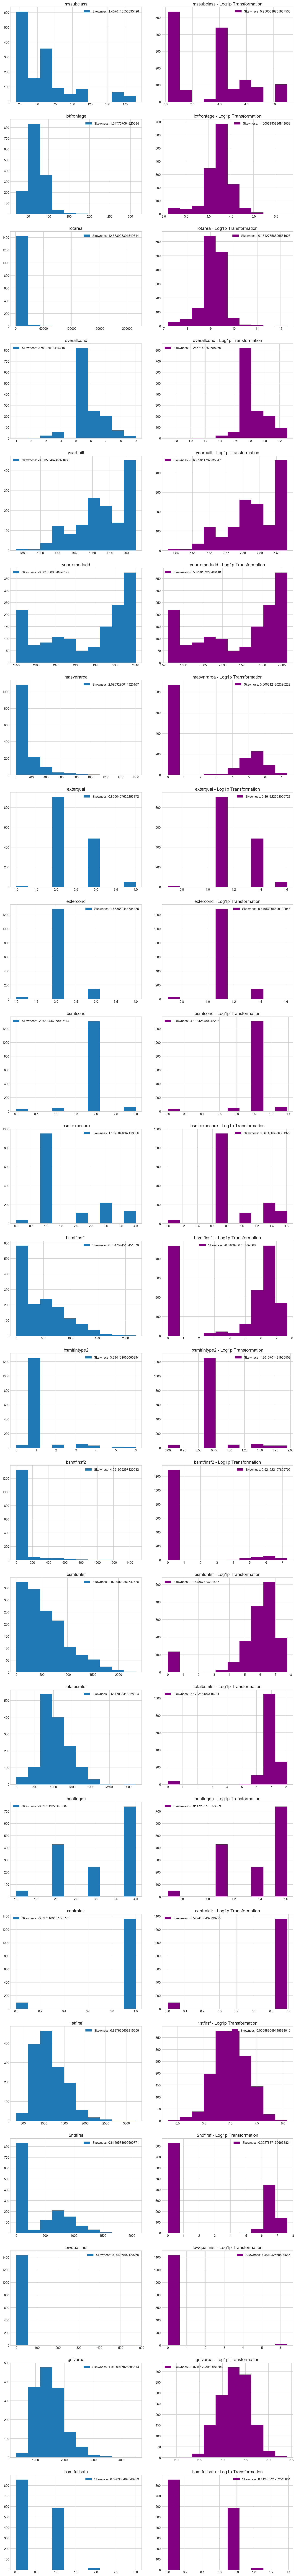

In [22]:
subplot_histograms(train, high_skewed)

#### Selected Columns from Plot Above to Log-Transform

In [23]:
# Selected Columns from Plot Above to Log-Transform
to_transform = ['lotfrontage', 'lotarea', 'overallcond', 'masvnrarea',
                'bsmtfinsf1', 'bsmtunfsf', '1stflrsf', 'grlivarea',
                'totrmsabvgrd', 'wooddecksf', 'openporchsf', 'totalarea',
                'totalsf']

for column in to_transform:
    train[column] = train[column].map(np.log1p)
    test[column] = test[column].map(np.log1p)

### 4.3 - Create New Polynomial Features for Columns with Strong Correlations with SalePrice

In [24]:
def polynomial_features(features, dataframes):
    for dataframe in dataframes:
        for feature in features:
            dataframe[str(feature)+ '^0.5'] = dataframe[feature].map(np.sqrt)
            dataframe[str(feature)+ '^2'] = dataframe[feature].map(lambda x: x**2)
            dataframe[str(feature)+ '^3'] = dataframe[feature].map(lambda x: x**3)

polynomial_features(strong_correlations, [train, test])

#### Boxplots for Nominal Variables

In [25]:
# defining a function to create boxplot for nominal variables
def subplot_boxplots(dataframe, list_of_columns):
      
    nrows = int(np.ceil(len(list_of_columns)/2)) # Makes sure you have enough rows
    
    fig, ax = plt.subplots(nrows=nrows,
                           ncols=2,
                           figsize=(14, 5 * nrows))
    plt.tight_layout(pad=4)
    ax = ax.ravel() 
    
    for index, column in enumerate(list_of_columns):
        
        sns.boxplot(x=dataframe[column], y=dataframe['saleprice'] ,ax=ax[index])
        ax[index].set_title(list_of_columns[index], size=14)
        ax[index].set_xlabel(list_of_columns[index], size=13)
        ax[index].set_ylabel('saleprice', size=13)

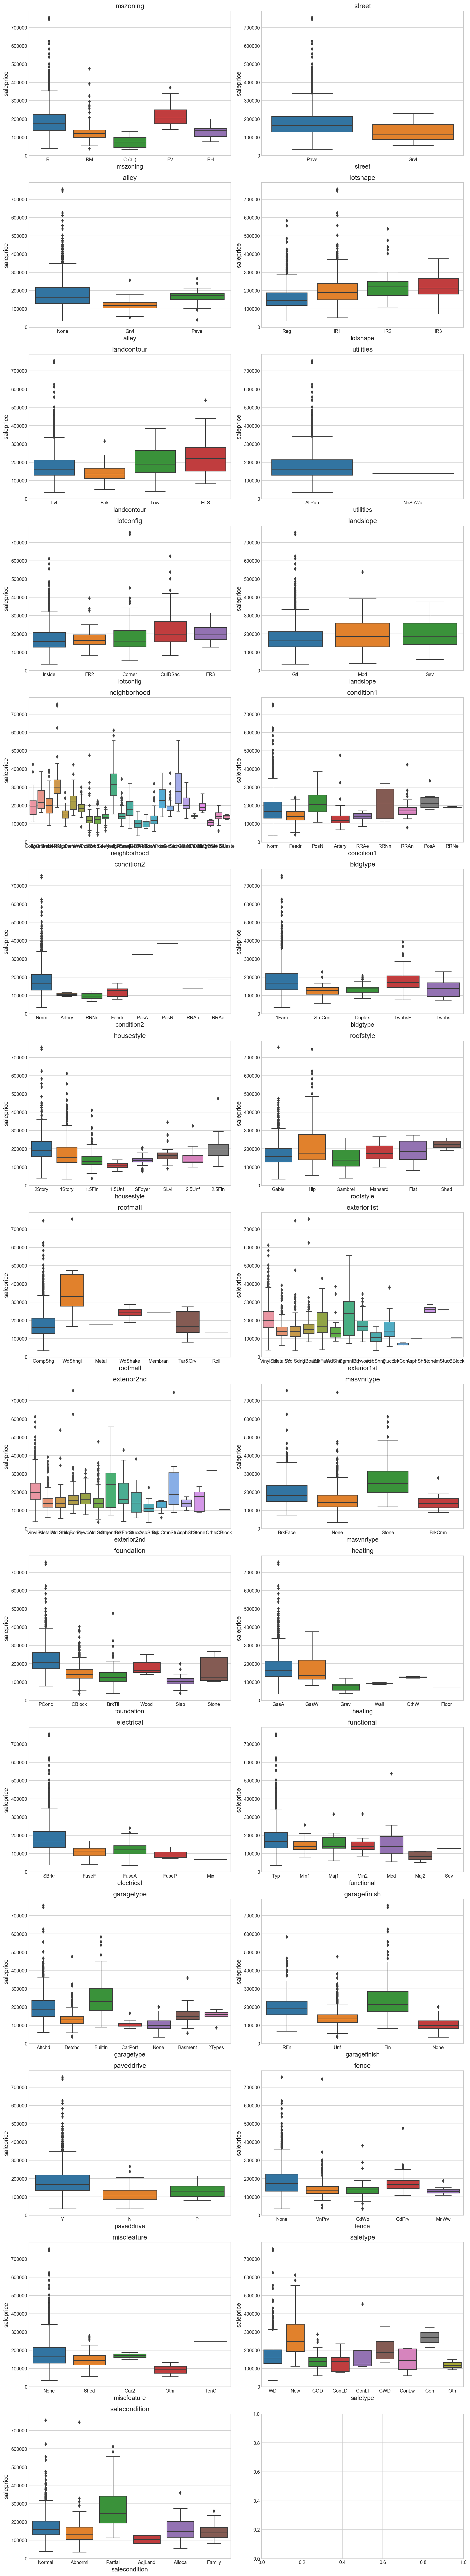

In [26]:
# plotting boxplots to look for nominal variables to be 'dummied'
subplot_boxplots(pd.concat([train['saleprice'],
                            train[nominal_variables]], axis=1),train[nominal_variables].columns)

## 4.4 - Creating Dummy Variables ( Qualitative )
> #### Variables with High Variation on Price

In [27]:
# creating a list of the variables to be dummied - chosen by analyzing boxplots
dummies_list = nominal_variables
train = pd.get_dummies(train, columns=dummies_list)
test = pd.get_dummies(test, columns=dummies_list)

## 6 - Modeling

In [28]:
# Define X and y
X = train.drop('saleprice', axis=1)
y = train['saleprice']

# Model Prep: Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.25, shuffle=True)

# Transform y to y_log - normalizing distribution
y_train_log = y_train.map(np.log1p)
y_test_log = y_test.map(np.log1p)
y_log = np.log1p(y)

In [29]:
# Null model - Baseline
y_train.mean()

180667.40347666972

In [30]:
results = []

#### GridSearchCV - Set Up Function to Run Models

In [31]:
# Define function to run Pipeline + GridSearchCV
def run_model_gs(pipeline, parameters, cv=11, results=results, model_name='',
                 X_train=X_train, X_test=X_test, y_train=y_train_log, y_test=y_test_log):

    results_dict = {}
    
    # Instantiate RandomizedSearchCV
    gs = GridSearchCV(pipeline,
                      parameters,
                      cv=cv,
                      verbose=1,
                      scoring='r2',
                      n_jobs=-1)
    
    # Fit GridSearch to training data
    gs.fit(X_train, y_train_log)
    
           
    # Best mean score out of cross validation out of all models tested (cvec)
    print(f'Best Score: {round(gs.best_score_,4)}')
    
    # Best Paramenters
    print(f'Best Parameters: {gs.best_params_}')
    
    # Save best model as gs_cvec_logreg_model
    gs_model = gs.best_estimator_
    
    # Score model on training set.
    print(f'Training R2 Score: {round(gs_model.score(X_train, y_train_log),4)}')

    # Score model on testing set.
    print(f'Testing R2 Score: {round(gs_model.score(X_test, y_test_log),4)}')
    
    # Predictions
    preds = gs_model.predict(X_test)
    
    print(f'Testing RMSE: {round(np.sqrt(mean_squared_error(y_test_log, preds)),4)}')
    print(f'Testing RMSLE: {round(np.sqrt(mean_squared_log_error(y_test_log, preds)),4)}')

    results_dict['model_name'] = model_name
    results_dict['training_r2'] = round(gs_model.score(X_train, y_train_log),4)
    results_dict['testing_r2'] = round(gs_model.score(X_test, y_test_log),4)
    results_dict['rmse'] = round(np.sqrt(mean_squared_error(y_test_log, preds)),4)
    results_dict['rmsle'] = round(np.sqrt(mean_squared_log_error(y_test_log, preds)),4)
    
    results.append(results_dict)
    
    return gs_model

In [32]:
pipeline_ridge = Pipeline(steps=[('scaler', RobustScaler()),
                                 ('ridge', Ridge())])

params_ridge = {
    'ridge__alpha': np.logspace(-3, 3, 10)
}

In [33]:
ridge = run_model_gs(pipeline_ridge, params_ridge, model_name='ridge')

Fitting 11 folds for each of 10 candidates, totalling 110 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.4s


Best Score: 0.92
Best Parameters: {'ridge__alpha': 10.0}
Training R2 Score: 0.9454
Testing R2 Score: 0.9231
Testing RMSE: 0.1118
Testing RMSLE: 0.0088


[Parallel(n_jobs=-1)]: Done 110 out of 110 | elapsed:    5.6s finished


In [34]:
np.expm1(ridge.predict(X_test))[:5]

array([228371.56048479,  98812.02741034, 104274.82242038, 163349.61752258,
       323943.87475009])

In [35]:
pipeline_lasso = Pipeline(steps=[('scaler', RobustScaler()),
                                 ('lasso', Lasso())])

params_lasso = {
    'lasso__alpha': np.logspace(-3, 3, 10),
}

In [36]:
lasso = run_model_gs(pipeline_lasso, params_lasso, model_name='lasso')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 11 folds for each of 10 candidates, totalling 110 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.0s


Best Score: 0.9177
Best Parameters: {'lasso__alpha': 0.001}
Training R2 Score: 0.9358
Testing R2 Score: 0.9283
Testing RMSE: 0.108
Testing RMSLE: 0.0085


[Parallel(n_jobs=-1)]: Done 110 out of 110 | elapsed:    5.3s finished


In [37]:
np.expm1(lasso.predict(X_test))[:5]

array([221852.30382871,  98876.42011677, 103708.52248885, 159240.66816805,
       328168.3635306 ])

In [38]:
pipeline_enet = Pipeline(steps=[('scaler', RobustScaler()),
                                ('enet', ElasticNet())])

params_enet = {
    'enet__alpha': np.logspace(-3,3,10),
    'enet__l1_ratio': [0.4]
}

In [39]:
enet = run_model_gs(pipeline_enet, params_enet, model_name='enet')

Fitting 11 folds for each of 10 candidates, totalling 110 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.2s


Best Score: 0.9211
Best Parameters: {'enet__alpha': 0.001, 'enet__l1_ratio': 0.4}
Training R2 Score: 0.9434
Testing R2 Score: 0.9281
Testing RMSE: 0.1081
Testing RMSLE: 0.0085


[Parallel(n_jobs=-1)]: Done 110 out of 110 | elapsed:    5.3s finished


In [40]:
np.expm1(enet.predict(X_test))[:5]

array([226233.7264149 ,  97571.35282103, 103672.9874562 , 161931.09461654,
       322526.55873392])

In [41]:
pipeline_br = Pipeline(steps=[('scaler', RobustScaler()),
                                ('br', BayesianRidge())])

params_br = {'br__n_iter': [200]
}

In [42]:
br = run_model_gs(pipeline_br, params_br, model_name='br')

Fitting 11 folds for each of 1 candidates, totalling 11 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Best Score: 0.9199
Best Parameters: {'br__n_iter': 200}
Training R2 Score: 0.9435
Testing R2 Score: 0.9233
Testing RMSE: 0.1117
Testing RMSLE: 0.0088


[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.7s finished


In [43]:
np.expm1(br.predict(X_test))[:5]

array([228225.17616162,  98669.99750766, 104462.7430761 , 163143.71815063,
       325529.72970168])

In [44]:
pipeline_rf = Pipeline(steps=[('scaler', RobustScaler()),
                                ('rf', RandomForestRegressor())])

params_rf = {'rf__n_estimators': [50],
             'rf__max_features': ['auto'],
             'rf__max_depth': [None],
             'rf__min_samples_split': [5],
             'rf__min_samples_leaf': [2]
}

In [45]:
rf = run_model_gs(pipeline_rf, params_rf, model_name='rf')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 11 folds for each of 1 candidates, totalling 11 fits


[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    5.7s finished


Best Score: 0.8799
Best Parameters: {'rf__max_depth': None, 'rf__max_features': 'auto', 'rf__min_samples_leaf': 2, 'rf__min_samples_split': 5, 'rf__n_estimators': 50}
Training R2 Score: 0.9731
Testing R2 Score: 0.8855
Testing RMSE: 0.1365
Testing RMSLE: 0.0107


In [46]:
np.expm1(rf.predict(X_test))[:5]

array([220323.73692466,  91829.26879489, 106107.87706786, 153740.36189389,
       302811.23573916])

In [47]:
pipeline_xgb = Pipeline(steps=[('scaler', RobustScaler()),
                               ('xgb', XGBRegressor())])

params_xgb = {
    'xgb__max_depth': [3],
    'xgb__learning_rate': [0.05],
    'xgb__n_estimators': [1000],
    'xgb__alpha': [0.01],
    'xgb__min_child_weight': [1],
    'xgb__gamma': [0],
    'xgb__colsample_bytree': [0.5],
    'xgb__ colsample_bylevel': [0.2],
    }

In [48]:
xgb = run_model_gs(pipeline_xgb, params_xgb, model_name='xgb')

Fitting 11 folds for each of 1 candidates, totalling 11 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:   56.8s finished


[23:36:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Best Score: 0.9085
Best Parameters: {'xgb__ colsample_bylevel': 0.2, 'xgb__alpha': 0.01, 'xgb__colsample_bytree': 0.5, 'xgb__gamma': 0, 'xgb__learning_rate': 0.05, 'xgb__max_depth': 3, 'xgb__min_child_weight': 1, 'xgb__n_estimators': 1000}
Training R2 Score: 0.9913
Testing R2 Score: 0.9163
Testing RMSE: 0.1167
Testing RMSLE: 0.0092


In [49]:
np.expm1(xgb.predict(X_test))[:5]

array([223963.42 ,  94386.86 , 106084.484, 152537.47 , 333216.53 ],
      dtype=float32)

In [50]:
pd.DataFrame(results)

,model_name,training_r2,testing_r2,rmse,rmsle
0,ridge,0.9454,0.9231,0.1118,0.0088
1,lasso,0.9358,0.9283,0.1080,0.0085
2,enet,0.9434,0.9281,0.1081,0.0085
3,br,0.9435,0.9233,0.1117,0.0088
4,rf,0.9731,0.8855,0.1365,0.0107
5,xgb,0.9913,0.9163,0.1167,0.0092


## 7 - Voting Regressor - Ensembing

In [51]:
vote = VotingRegressor(estimators=[('Ridge', ridge), ('Lasso', lasso), ('ElasticNet', enet),
                      ('BayesianRidge', br), ('RandomForestRegressor', rf), ('XGBRegressor', xgb)],
                      n_jobs=-1)

vote = vote.fit(X_train, y_train_log)

# Score model on training set.
print(f'Training Accuracy Score: {vote.score(X_train, y_train_log)}')

# Score model on testing set.
print(f'Testing Accuracy Score: {vote.score(X_test, y_test_log)}')

# Predictions
preds = vote.predict(X_test)

print(f'RMSE: {np.sqrt(mean_squared_error(y_test_log, preds))}')
print(f'RMSLE: {np.sqrt(mean_squared_log_error(y_test_log, preds))}')

Training Accuracy Score: 0.9627848534624031
Testing Accuracy Score: 0.9275185984134497
RMSE: 0.10856208258238835
RMSLE: 0.008553191219348489


## 8 - Plotting Predictions

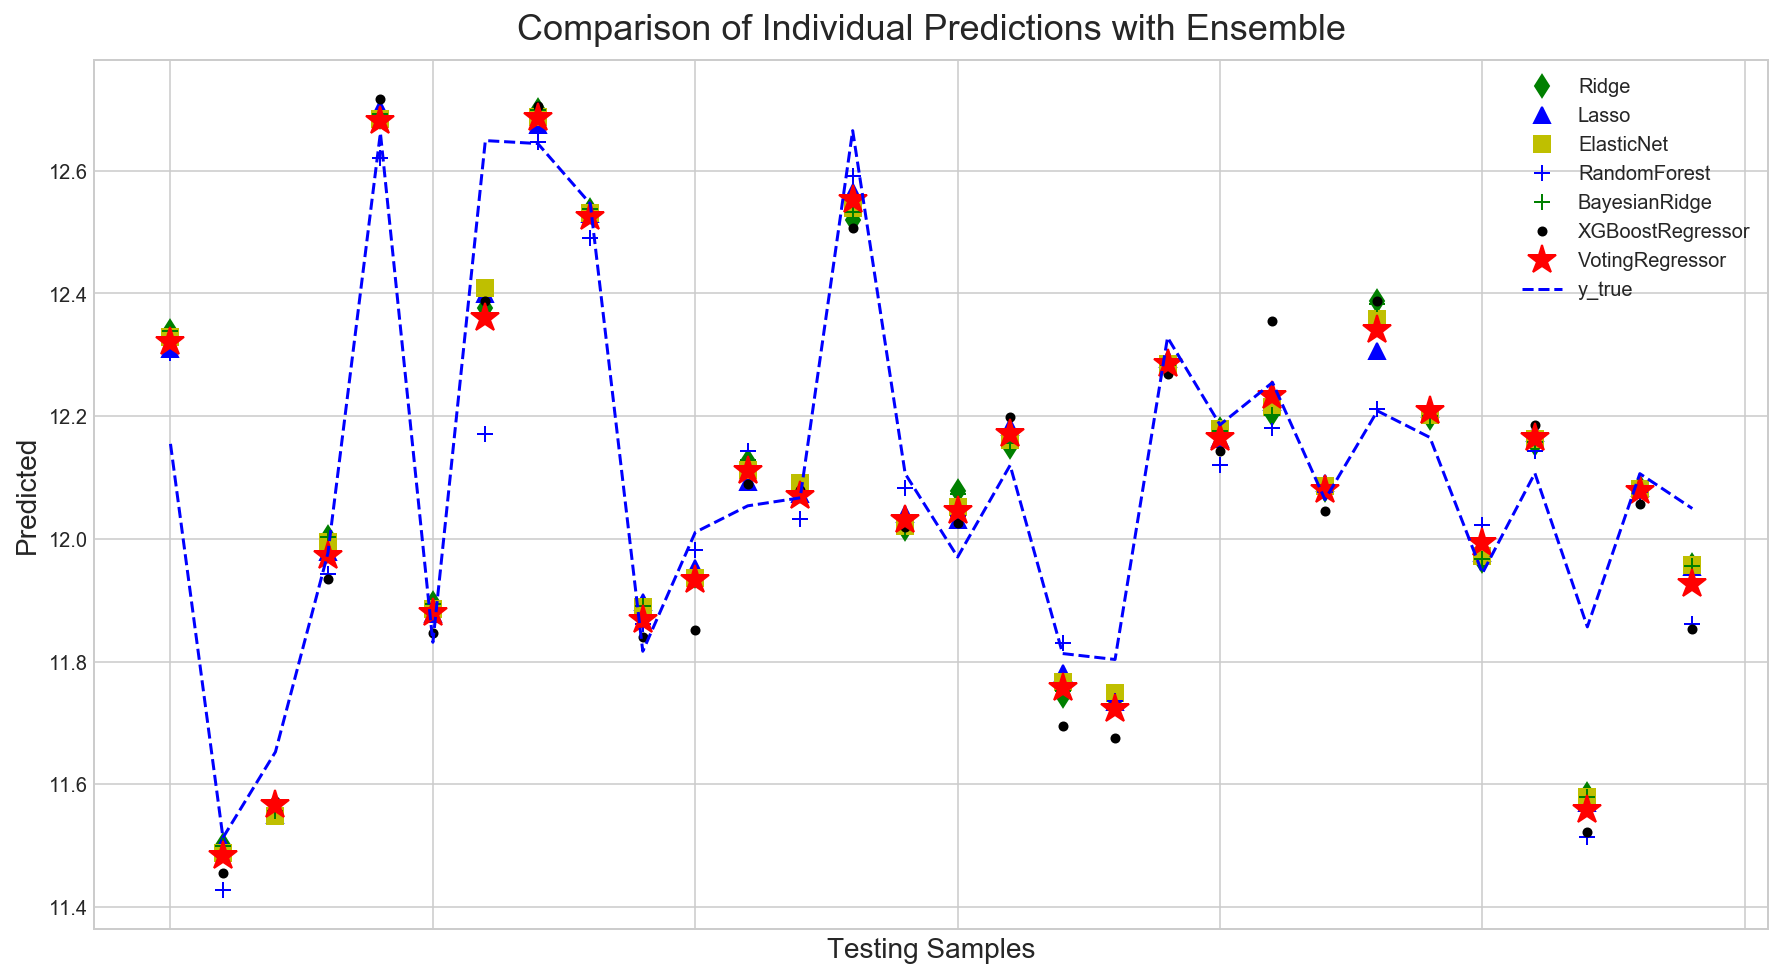

In [52]:
# https://scikit-learn.org/stable/auto_examples/ensemble/plot_voting_regressor.html \
#sphx-glr-auto-examples-ensemble-plot-voting-regressor-py
plt.figure(figsize=(15,8))
plt.plot(ridge.predict(X_test[:30]), 'gd', label='Ridge', ms=8)
plt.plot(lasso.predict(X_test[:30]), 'b^', label='Lasso', ms=8)
plt.plot(enet.predict(X_test[:30]), 'ys', label='ElasticNet', ms=8)
plt.plot(rf.predict(X_test[:30]), 'b+', label='RandomForest', ms=8)
plt.plot(br.predict(X_test[:30]), 'g+', label='BayesianRidge', ms=8)
plt.plot(xgb.predict(X_test[:30]), 'k.', label='XGBoostRegressor', ms=8)
plt.plot(vote.predict(X_test[:30]), 'r*', label='VotingRegressor', ms=15)
plt.plot(np.log1p(y_test.values[:30]),'b--', label='y_true', ms=15)

plt.tick_params(axis='x', which='both', bottom=False, top=False,
                labelbottom=False)
plt.ylabel('Predicted', size=14)
plt.xlabel('Testing Samples', size=14)
plt.legend(loc="best")
plt.title('Comparison of Individual Predictions with Ensemble', size=18, pad=10);

In [53]:
preds = pd.Series(np.expm1(vote.predict(X_test)), name='preds')
residuals =  pd.Series(preds - y_test.reset_index(drop=True), name='residuals')

In [54]:
preds_df = pd.concat([y_test.reset_index(drop=True), preds, residuals], axis=1)
preds_df.head()

,saleprice,preds,residuals
0,190000,224171.127931,34171.127931
1,100000,97040.446401,-2959.553599
2,115000,105514.785966,-9485.214034
3,159000,158298.860373,-701.139627
4,315500,321864.795141,6364.795141


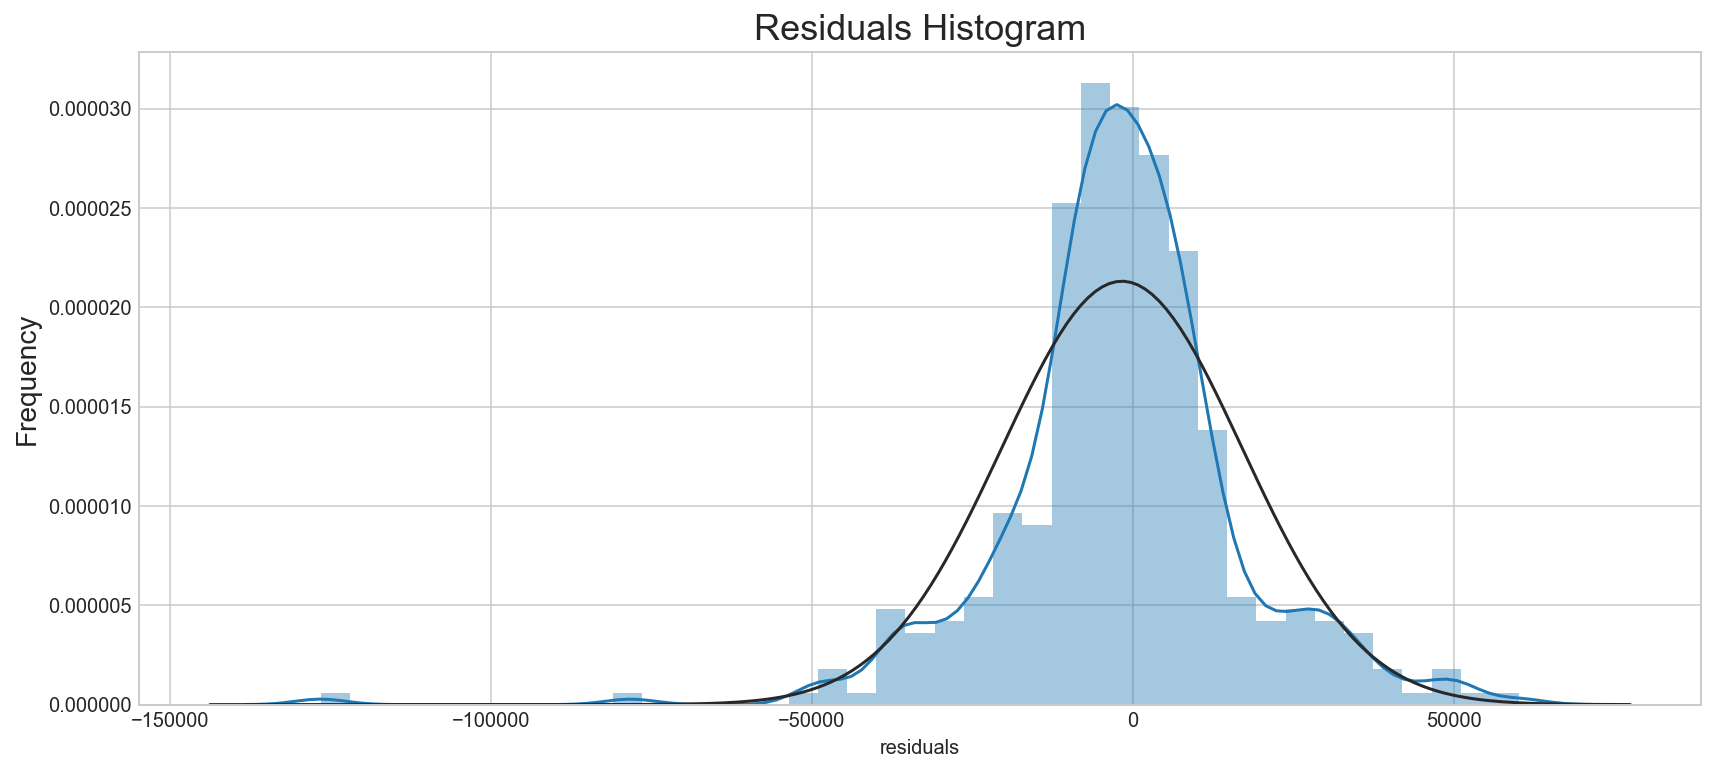

In [55]:
# plotting residuals histogram
plt.figure(figsize=(14,6))
sns.distplot(residuals, fit=norm)
plt.title('Residuals Histogram', size=18)
plt.ylabel('Frequency', size=14);

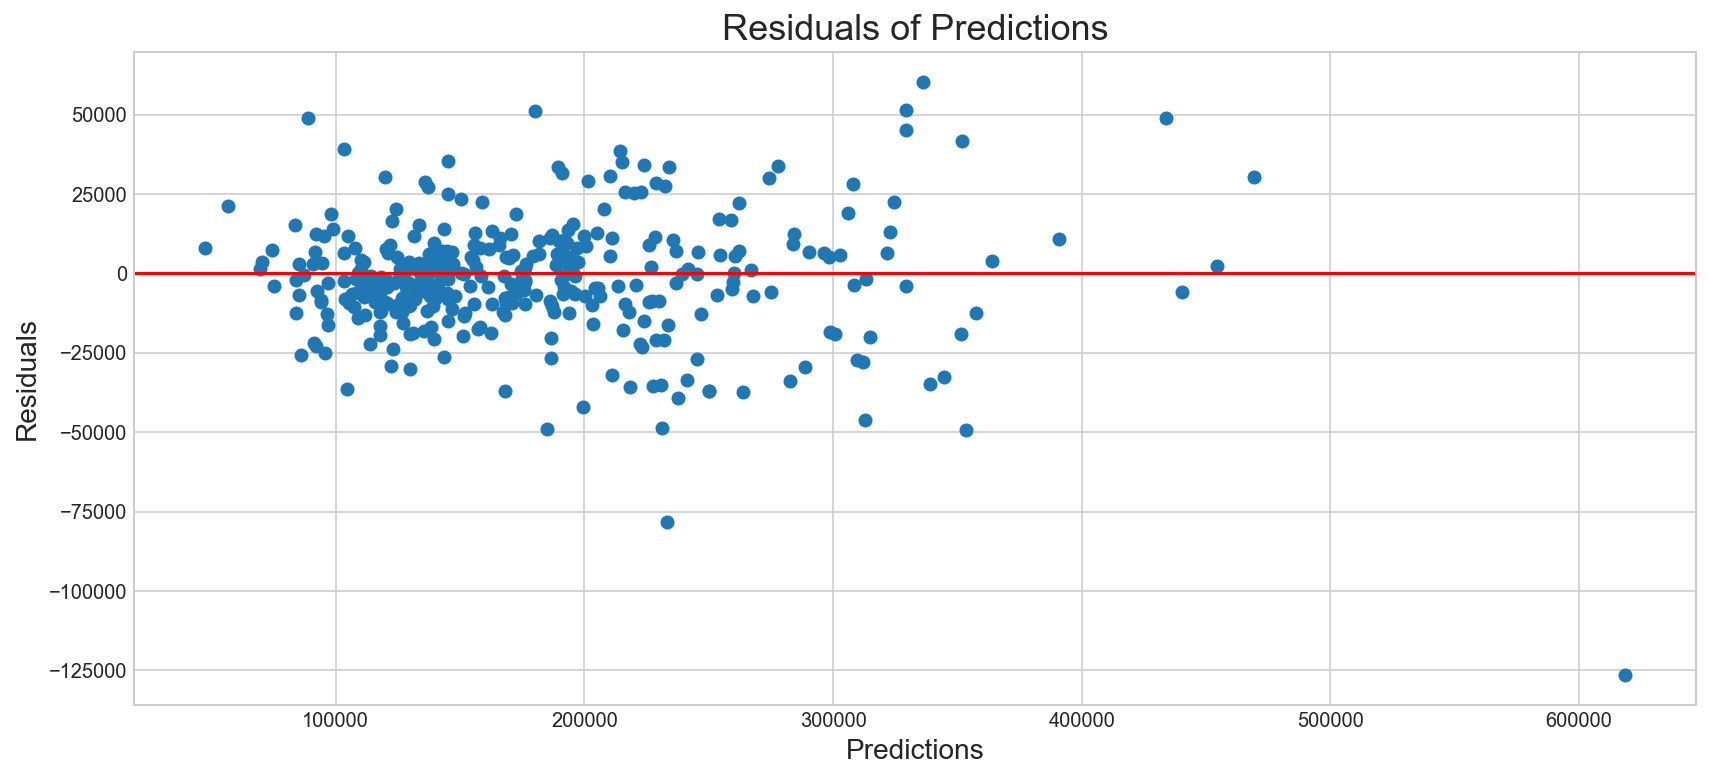

In [56]:
# plotting scatter for predictions and residuals
plt.figure(figsize=(14,6))
plt.scatter(preds, residuals)
plt.axhline(color='r')
plt.title('Residuals of Predictions', size=18)
plt.xlabel('Predictions', size=14)
plt.ylabel('Residuals', size=14);

## 8 - Kaggle Predictions

In [57]:
# inputting 0 for columns that do not exist on test set
missing_cols = []
for column in train[X.columns].columns:
    if column not in test.columns and column != 'saleprice':
        missing_cols.append(column)
        test[column] = 0

print(missing_cols)
print(f'Train Shape: {train.shape}')
print(f'Test Shape: {test.shape}')

['utilities_NoSeWa', 'condition2_RRAe', 'condition2_RRAn', 'condition2_RRNn', 'housestyle_2.5Fin', 'roofmatl_Membran', 'roofmatl_Metal', 'roofmatl_Roll', 'exterior1st_ImStucc', 'exterior1st_Stone', 'exterior2nd_Other', 'heating_Floor', 'heating_OthW', 'electrical_Mix', 'miscfeature_TenC']
Train Shape: (1458, 297)
Test Shape: (1459, 296)


In [58]:
results = {}

In [59]:
# Refit Models on All Training Data
ridge.fit(X, y_log)
lasso.fit(X, y_log)
enet.fit(X, y_log)
rf.fit(X, y_log)
br.fit(X, y_log)
xgb.fit(X, y_log)
vote.fit(X, y_log);

[23:37:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [60]:
results['ridge_preds'] = np.expm1(ridge.predict(X))
results['lasso_preds'] = np.expm1(lasso.predict(X))
results['enet_preds'] = np.expm1(enet.predict(X))
results['br_preds'] = np.expm1(br.predict(X))
results['rf_preds'] = np.expm1(rf.predict(X))
results['xgb_preds'] = np.expm1(xgb.predict(X))
results['vote_preds'] = np.expm1(vote.predict(X))

In [61]:
results = pd.DataFrame(results)
results.head()

,ridge_preds,lasso_preds,enet_preds,br_preds,rf_preds,xgb_preds,vote_preds
0,204703.500858,206012.946324,204794.387150,204810.756712,207706.295803,207390.578125,206008.708322
1,190041.182888,189872.445892,189653.419412,190076.088574,179990.007750,177862.187500,185650.041550
2,216339.257639,219613.609980,217503.888466,216576.769004,222140.990866,214479.531250,217579.270550
3,166709.383467,170001.378000,171026.934830,166711.275035,150549.715189,142566.906250,162244.252203
4,293184.231359,293124.171883,294519.057665,293043.292178,258775.636286,276094.343750,284589.545317


In [62]:
preds = results['vote_preds']

print(f'RMSE: {np.sqrt(mean_squared_error(y, preds))}')
print(f'RMSLE: {np.sqrt(mean_squared_log_error(y, preds))}')

RMSE: 14492.844197670864
RMSLE: 0.0784903786243762


In [63]:
kaggle_predictions = pd.DataFrame()
kaggle_predictions['Id'] = test_id
kaggle_predictions['SalePrice'] = np.expm1(vote.predict(test[X.columns]))
kaggle_predictions[:5]

,Id,SalePrice
0,1461,121692.794244
1,1462,160199.160987
2,1463,182426.707078
3,1464,195503.520966
4,1465,191921.469573


In [64]:
kaggle_predictions.to_csv('../data/submission.csv', index=False)